In [1]:
EASY_MODE = True        #If True, only translates phrases shorter than 20 characters (way easier).
                        #Useful for initial coding.
                        #If false, works with all phrases (please switch to this mode for homework assignment)

MODE = "he-to-en"                                #way we translate. Either "he-to-en" or "en-to-he"
MAX_OUTPUT_LENGTH = 50 if not EASY_MODE else 20  #maximal length of _generated_ output, does not affect training
REPORT_FREQ       = 100                          #how often to evaluate validation score

In [2]:
import numpy as np
from collections import defaultdict
word_to_translation = defaultdict(list) # our dictionary

bos = '_'
eos = ';'

with open("main_dataset.txt") as fin:
    for line in fin:
        en, he = line[:-1].lower().replace(bos,' ').replace(eos,' ').split('\t')
        word, trans = (he, en) if MODE == 'he-to-en' else (en, he)
        
        if len(word) < 3: continue
        if EASY_MODE:
            if max(len(word), len(trans)) > 20:
                continue
        
        word_to_translation[word].append(trans)

In [3]:
# get all unique lines in source language
all_words = np.array(list(word_to_translation.keys()))
# get all unique lines in translation language
all_translations = np.array([ts for all_ts in word_to_translation.values() for ts in all_ts])

In [4]:
from sklearn.model_selection import train_test_split
train_words, test_words = train_test_split(all_words, test_size=0.1, random_state=42)

In [5]:
from voc import Vocab
inp_voc = Vocab.from_lines(''.join(all_words), bos=bos, eos=eos, sep='')
out_voc = Vocab.from_lines(''.join(all_translations), bos=bos, eos=eos, sep='')

In [6]:
import tensorflow as tf
tf.reset_default_graph()
s = tf.InteractiveSession()

# ^^^ if you get "variable *** already exists": re-run this cell again

In [7]:
from attention_model import AttentionBilinearGRUTranslationModel
model = AttentionBilinearGRUTranslationModel(
    'model', inp_voc, out_voc,
    emb_size=32, hid_size=64
)

# PLEASE DON'T CHANGE THESE VALUES: emb_size=32, hid_size=64

s.run(tf.global_variables_initializer())

Using TensorFlow backend.


In [8]:
# Prepare any operations you want here
input_sequence = tf.placeholder('int32', [None, None])
greedy_translations, logp = model.symbolic_translate(input_sequence, greedy=True)

def translate(lines):
    """
    You are given a list of input lines. 
    Make your neural network translate them.
    :return: a list of output lines
    """
    # Convert lines to a matrix of indices
    lines_ix = inp_voc.to_matrix(lines)

    # Compute translations in form of indices
    trans_ix = s.run(greedy_translations, {input_sequence: lines_ix})

    # Convert translations back into strings
    return out_voc.to_lines(trans_ix)

In [9]:
import editdistance # !pip install editdistance

def get_distance(word, trans):
    """
    A function that takes word and predicted translation
    and evaluates (Levenshtein's) edit distance to closest correct translation
    """
    references = word_to_translation[word]
    assert len(references) != 0, "wrong/unknown word"
    return min(editdistance.eval(trans, ref) for ref in references)

def score(words, bsize=100):
    """a function that computes levenshtein distance for bsize random samples"""
    assert isinstance(words, np.ndarray)
    
    batch_words = np.random.choice(words, size=bsize, replace=False)
    batch_trans = translate(batch_words)

    distances = list(map(get_distance, batch_words, batch_trans))

    return np.array(distances, dtype='float32')

In [10]:
# import utility functions
from basic_model import initialize_uninitialized, infer_length, infer_mask, select_values_over_last_axis

class supervised_training:
    # variable for inputs and correct answers
    input_sequence = tf.placeholder('int32', [None, None])
    reference_answers = tf.placeholder('int32', [None, None])

    # Compute log-probabilities of all possible tokens at each step. Use model interface.
    logprobs_seq = model.symbolic_score(input_sequence, reference_answers)

    # compute mean crossentropy
    crossentropy = -select_values_over_last_axis(logprobs_seq, reference_answers)
    mask = infer_mask(reference_answers, out_voc.eos_ix)
    loss = tf.reduce_sum(crossentropy * mask) / tf.reduce_sum(mask)
    # Build weights optimizer. Use model.weights to get all trainable params.
    
#    learning_rate = tf.Variable(0.001)
    train_step = tf.train.AdamOptimizer().minimize(
        loss, var_list=model.weights
    )

# intialize optimizer params while keeping model intact
initialize_uninitialized(s)

In [11]:
import random
def sample_batch(words, word_to_translation, batch_size):
    """
    sample random batch of words and random correct translation for each word
    example usage:
    batch_x,batch_y = sample_batch(train_words, word_to_translations,10)
    """
    #choose words
    batch_words = np.random.choice(words, size=batch_size)
    
    #choose translations
    batch_trans_candidates = list(map(word_to_translation.get,batch_words))
    batch_trans = list(map(random.choice, batch_trans_candidates))
    
    return inp_voc.to_matrix(batch_words), out_voc.to_matrix(batch_trans)

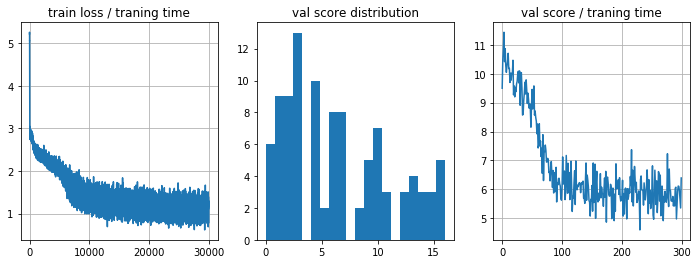

100%|██████████| 30000/30000 [34:33<00:00, 14.47it/s]

llh=1.174, mean score=5.801


In [12]:
from IPython.display import clear_output
from tqdm import tqdm, trange #or use tqdm_notebook,tnrange
from matplotlib import pyplot as plt

loss_history = []
editdist_history = []

for i in trange(30000):
    bx, by = sample_batch(train_words, word_to_translation, 32)

    feed_dict = {
        supervised_training.input_sequence: bx,
        supervised_training.reference_answers: by
    }

    s.run(supervised_training.train_step, feed_dict)
    loss = s.run(supervised_training.loss, feed_dict)
    loss_history.append(loss)

#    if loss < 1.3:
#        supervised_training.learning_rate = 0.0001

    if (i + 1) % REPORT_FREQ == 0:
        clear_output(True)
        current_scores = score(test_words)
        editdist_history.append(current_scores.mean())
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.title('train loss / traning time')
        plt.plot(loss_history)
        plt.grid()
        plt.subplot(132)
        plt.title('val score distribution')
        plt.hist(current_scores, bins=20)
        plt.subplot(133)
        plt.title('val score / traning time')
        plt.plot(editdist_history)
        plt.grid()
        plt.show()
        print("llh={0:.3f}, mean score={1:.3f}".format(
            np.mean(loss_history[-10:]), np.mean(editdist_history[-10:])
        ))

# Note: it's okay if loss oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [13]:
for word in train_words[:10]:
    print("%s -> %s"%(word, translate([word])[0]))

כל אנשי סמיילי -> anshi smayli sea
קטגוריה:ערוץ 2 -> seation of chanorich
עבודה מהבית -> and of dome
פראליה -> pralia
קפלר 42 -> chepeller 42
קטגוריה:מתאסלמים -> matasslamism
בושמי -> boshmi
לאונרדו -> leonardo
שאמה -> shama
עכברה -> anchand of sea


In [14]:
test_scores = []
for start_i in trange(0, len(test_words), 32):
    batch_words = test_words[start_i:(start_i + 32)]
    batch_trans = translate(batch_words)
    distances = list(map(get_distance, batch_words, batch_trans))
    test_scores.extend(distances)
    
print("Supervised test score:", np.mean(test_scores))

100%|██████████| 407/407 [00:11<00:00, 36.27it/s]

Supervised test score: 5.86781432524


encoder в используемой модели - двунаправленный rnn c GRU ячейкой. Ячейки декодера - тоже GRU. При переводе используется attention, который генерируя новый cимвол позволяет смотреть на исходное слово. Это работает лучше, чем любой LSTM/GRU двунаправленный/однонапрвленный, который не умеет смотреть на исходные токены при генерации новых. Attention использует билинейную функцию с тренеруемой матрицей. Он описан в attention_layer.py. Это работает лучше, чем все, что пробовал. При обучении немного увеличил число батчей, потому что с меньшим не всегда доходило до нужного качества.